<a href="https://colab.research.google.com/github/kelgruber/bear-cnn-classification/blob/main/Kel_Gruber_Practice_Task_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Practice Project Task 5 Using Pre-trained Models and Recent Architectures

Kel Gruber

## Dataset - Bears Classification
Goal is to classify images of grizzly, panda, and polar bears.
Dataset was created by Shaney Flores and consists of over 1000 digital colored images of grizzly, panda, and polar bears were downloaded from an Internet image search.
Dataset can be found and downloaded from [Shaney Flores's Github](https://github.com/shaneyflores/Classifying-Bear-Species-DL/blob/main/bears_ws.zip).

In [ ]:
# how to get training time:

start_time = time.time()
end_time = time.time()

# calculate training time with end_time - start_time
# add a print statement with the time in seconds, can convert to others


SyntaxError: invalid syntax (<ipython-input-1-d7975b891ec0>, line 1)

##1. Load Dataset and Preview Images
For reproducibility the dataset has been split before we begin into 3 sets, the training, validation and testing sets. The training set contains approximately 60% of the data, and the validation and testing sets each contain 20% of the data.

### Import libaries and connect to Drive

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Import Dataset from Drive and Unzip

In [ ]:
import zipfile
import os
zip_train = zipfile.ZipFile('/content/drive/MyDrive/Bears Classification/bears_ws.zip')
zip_train.extractall('/tmp')
zip_train.close()

###Import Training, Validation, and Testing Datasets

In [ ]:
image_generator = ImageDataGenerator(rescale=1./255)

training_data = image_generator.flow_from_directory( '/tmp/bears/training', target_size=(224, 224), batch_size=1, class_mode='categorical')
print(training_data.image_shape)

validation_set = image_generator.flow_from_directory( '/tmp/bears/validation', target_size=(224, 224), batch_size=1, class_mode='categorical')
print(validation_set.image_shape)

testing_set = image_generator.flow_from_directory( '/tmp/bears/test', target_size=(224, 224), batch_size=1, class_mode='categorical')
print(testing_set.image_shape)

Found 718 images belonging to 3 classes.
(224, 224, 3)
Found 240 images belonging to 3 classes.
(224, 224, 3)
Found 240 images belonging to 3 classes.
(224, 224, 3)


###View Some Examples from the Training Dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

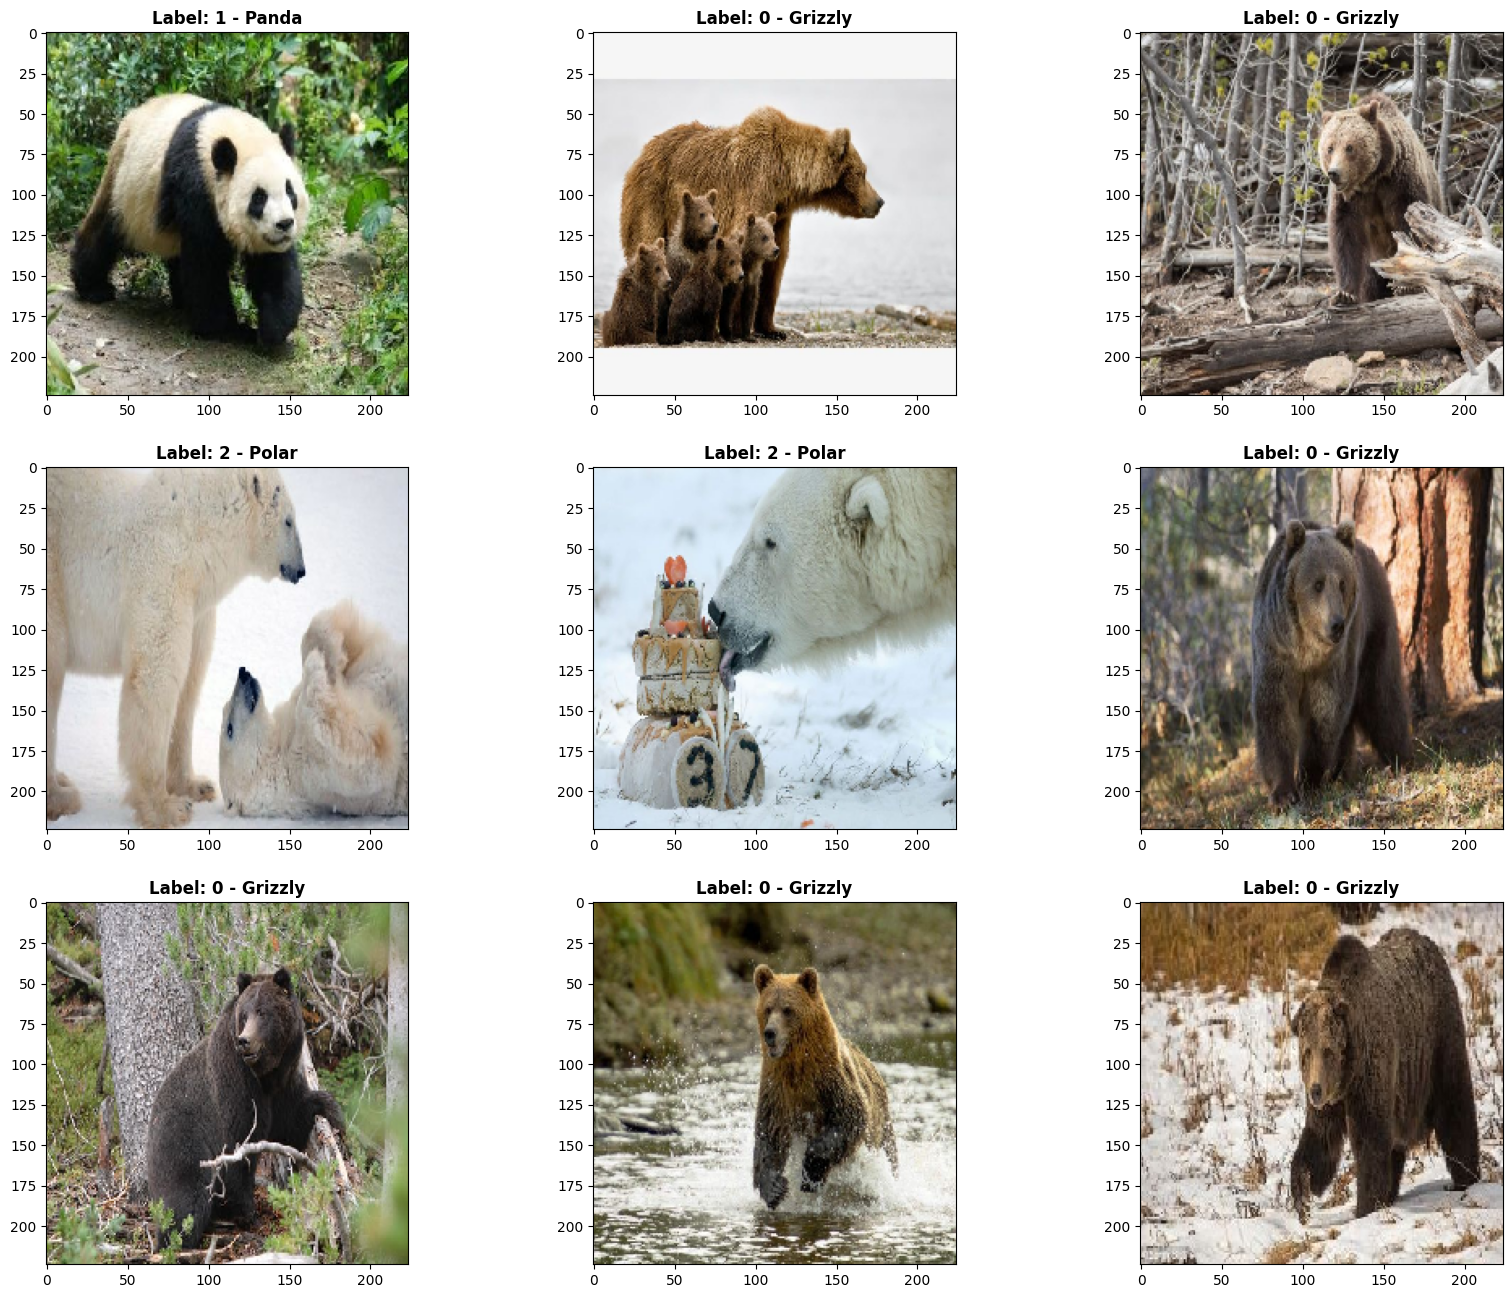

In [ ]:
label_category = {0: "Grizzly", 1: "Panda", 2: "Polar"}

images = []
labels = []
for i in range(9):
    image, label = next(training_data)
    images.append(image)
    labels.append(label)

labels = np.array(labels)
labels = np.squeeze(labels)
labels = np.argmax(labels, axis=1)
labels = list(labels)

# Plotting the images
plt.figure(figsize=(20,16))
for i in range(0,9):
    row = i // 3  # Calculate row index
    column = i % 3  # Calculate column index
    plt.subplot(3, 3, i + 1)
    plt.title(f'Label: {labels[i]} - {label_category[labels[i]]}',fontweight='bold')
    plt.imshow(images[i].squeeze())
plt.show()

##2. Using Pre-trained Models

Our goal in this phase is to improve our accuracy on the validation set but using more powerful architectures such as ResNet, DenseNet, or NASNet, and using pre-trained models such as VGG16 or ResNet50.

In [ ]:
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.applications import VGG16, DenseNet121, ResNet50

###2.1 VGG16

####Load and Preview Model Base

In [ ]:
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
vgg_base.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

####Train Model

In [ ]:
import re
vgg_base.trainable = False
for layer in vgg_base.layers:
    if bool(re.search('block5',layer.name)):
      layer.trainable = True
      print(layer.name,": Trainable")

block5_conv1 : Trainable
block5_conv2 : Trainable
block5_conv3 : Trainable
block5_pool : Trainable


In [ ]:
model_V2 = Sequential()
model_V2.add( vgg_base )
model_V2.add( Flatten() )
model_V2.add( Dense(units=64, activation = 'relu' , input_dim = 7 * 7 * 512) )
model_V2.add( layers.Dropout(0.4) )
model_V2.add( Dense(units=3, activation = 'softmax' ) )
model_V2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_6 (Flatten)         (None, 25088)             0         
                                                                 
 dense_16 (Dense)            (None, 64)                1605696   
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 dense_17 (Dense)            (None, 3)                 195       
                                                                 
Total params: 16320579 (62.26 MB)
Trainable params: 1605891 (6.13 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience = 20, verbose=1)
model_V2.compile( optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = 'accuracy')
model_V2_history = model_V2.fit( training_data, validation_data = validation_set, epochs = 100, batch_size = 64, callbacks = [callback_b])

Epoch 1/100
718/718 [==============================] - 16s 18ms/step - loss: 1.1964 - accuracy: 0.6198 - val_loss: 0.3809 - val_accuracy: 0.8750
Epoch 2/100
718/718 [==============================] - 16s 22ms/step - loss: 0.7327 - accuracy: 0.7786 - val_loss: 0.4070 - val_accuracy: 0.8792
Epoch 3/100
718/718 [==============================] - 10s 14ms/step - loss: 0.4693 - accuracy: 0.8565 - val_loss: 0.6578 - val_accuracy: 0.9042
Epoch 4/100
718/718 [==============================] - 10s 14ms/step - loss: 0.4505 - accuracy: 0.8621 - val_loss: 0.3435 - val_accuracy: 0.9208
Epoch 5/100
718/718 [==============================] - 10s 14ms/step - loss: 0.4166 - accuracy: 0.8928 - val_loss: 0.3305 - val_accuracy: 0.9500
Epoch 6/100
718/718 [==============================] - 10s 15ms/step - loss: 0.3292 - accuracy: 0.9136 - val_loss: 0.4868 - val_accuracy: 0.8875
Epoch 7/100
718/718 [==============================] - 11s 15ms/step - loss: 0.2895 - accuracy: 0.9136 - val_loss: 0.4640 - val_ac

####View Learning Curves

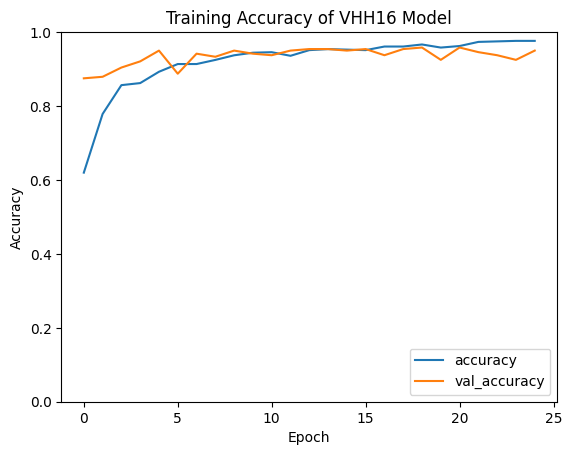

In [ ]:
plt.title('Training Accuracy of VHH16 Model')
plt.plot(model_V2_history.history['accuracy'], label='accuracy')
plt.plot(model_V2_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

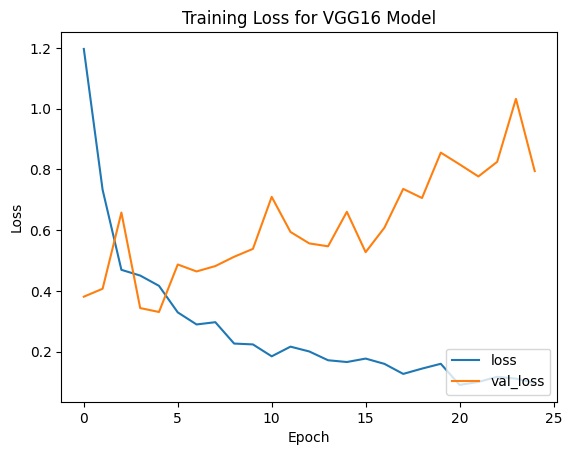

In [ ]:
plt.title('Training Loss for VGG16 Model')
plt.plot(model_V2_history.history['loss'], label='loss')
plt.plot(model_V2_history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

####Evaluate Model

In [ ]:
val_loss, val_acc = model_V2.evaluate(validation_set)

print(f'Accuracy: {val_acc*100.0}')
print(f'Loss:{val_loss}')

240/240 [==============================] - 3s 11ms/step - loss: 0.7942 - accuracy: 0.9500
Accuracy: 94.9999988079071
Loss:0.7942466139793396


In [ ]:
# Get predictions from model
P = [] # empty list of predictions
Y_true = []
for i in range(len(validation_set)):
   x, y = validation_set.next()
   p = model_V2.predict(x, verbose = 0)
   Y_true.extend(y)
   P.extend(p)

In [ ]:
# Convert predicted probabilities to binary predictions (0 or 1)
Y_pred = np.argmax(P, axis=1)
Y_true = np.argmax(Y_true, axis=1)

accuracy = accuracy_score(Y_true, Y_pred)
precision = precision_score(Y_true, Y_pred, average='weighted')
recall = recall_score(Y_true, Y_pred, average='weighted')
f1 = f1_score(Y_true, Y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.95
Precision: 0.9500105218855219
Recall: 0.95
F1 Score: 0.9499061827533722


###2.2 DenseNet121


####Load and Preview Model Base

In [ ]:
dense_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(224,224,3))
dense_base.summary()

29084464/29084464 [==============================] - 2s 0us/step
Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_2[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormali

####Train Model

In [ ]:
import re
dense_base.trainable = False
for layer in dense_base.layers:
    if bool(re.search('conv5',layer.name)):
      layer.trainable = True
      print(layer.name,": Trainable")

conv5_block1_0_bn : Trainable
conv5_block1_0_relu : Trainable
conv5_block1_1_conv : Trainable
conv5_block1_1_bn : Trainable
conv5_block1_1_relu : Trainable
conv5_block1_2_conv : Trainable
conv5_block1_concat : Trainable
conv5_block2_0_bn : Trainable
conv5_block2_0_relu : Trainable
conv5_block2_1_conv : Trainable
conv5_block2_1_bn : Trainable
conv5_block2_1_relu : Trainable
conv5_block2_2_conv : Trainable
conv5_block2_concat : Trainable
conv5_block3_0_bn : Trainable
conv5_block3_0_relu : Trainable
conv5_block3_1_conv : Trainable
conv5_block3_1_bn : Trainable
conv5_block3_1_relu : Trainable
conv5_block3_2_conv : Trainable
conv5_block3_concat : Trainable
conv5_block4_0_bn : Trainable
conv5_block4_0_relu : Trainable
conv5_block4_1_conv : Trainable
conv5_block4_1_bn : Trainable
conv5_block4_1_relu : Trainable
conv5_block4_2_conv : Trainable
conv5_block4_concat : Trainable
conv5_block5_0_bn : Trainable
conv5_block5_0_relu : Trainable
conv5_block5_1_conv : Trainable
conv5_block5_1_bn : Traina

In [ ]:
model_D = Sequential()
model_D.add( dense_base)
model_D.add( Flatten())
model_D.add( Dense(units=25, activation = 'relu' , input_dim = 7 * 7 * 1920))
model_D.add( Dense(units=3, activation = 'softmax' ) )
model_D.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 flatten_2 (Flatten)         (None, 50176)             0         
                                                                 
 dense_4 (Dense)             (None, 25)                1254425   
                                                                 
 dense_5 (Dense)             (None, 3)                 78        
                                                                 
Total params: 8292007 (31.63 MB)
Trainable params: 1254503 (4.79 MB)
Non-trainable params: 7037504 (26.85 MB)
_________________________________________________________________


In [ ]:
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience = 20, verbose=1)
model_D.compile( optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = 'accuracy')
model_D_history = model_D.fit( training_data, validation_data = validation_set, epochs = 100, batch_size = 64, callbacks = [callback_b] )

Epoch 1/100
718/718 [==============================] - 31s 32ms/step - loss: 1.4531 - accuracy: 0.7967 - val_loss: 0.4996 - val_accuracy: 0.9125
Epoch 2/100
718/718 [==============================] - 19s 26ms/step - loss: 0.2435 - accuracy: 0.9554 - val_loss: 0.5420 - val_accuracy: 0.9125
Epoch 3/100
718/718 [==============================] - 16s 22ms/step - loss: 0.0699 - accuracy: 0.9833 - val_loss: 0.2671 - val_accuracy: 0.9708
Epoch 4/100
718/718 [==============================] - 18s 25ms/step - loss: 0.0447 - accuracy: 0.9903 - val_loss: 0.2369 - val_accuracy: 0.9750
Epoch 5/100
718/718 [==============================] - 15s 22ms/step - loss: 2.4143e-04 - accuracy: 1.0000 - val_loss: 0.1703 - val_accuracy: 0.9833
Epoch 6/100
718/718 [==============================] - 16s 22ms/step - loss: 5.2972e-06 - accuracy: 1.0000 - val_loss: 0.2232 - val_accuracy: 0.9750
Epoch 7/100
718/718 [==============================] - 19s 26ms/step - loss: 5.9948e-07 - accuracy: 1.0000 - val_loss: 0.1

####View Learning Curves

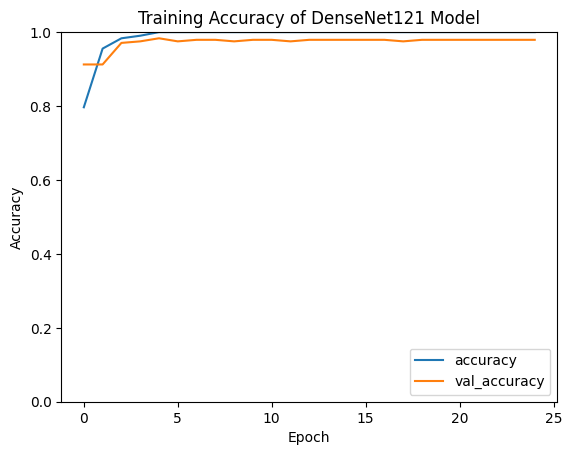

In [ ]:
plt.title('Training Accuracy of DenseNet121 Model')
plt.plot(model_D_history.history['accuracy'], label='accuracy')
plt.plot(model_D_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

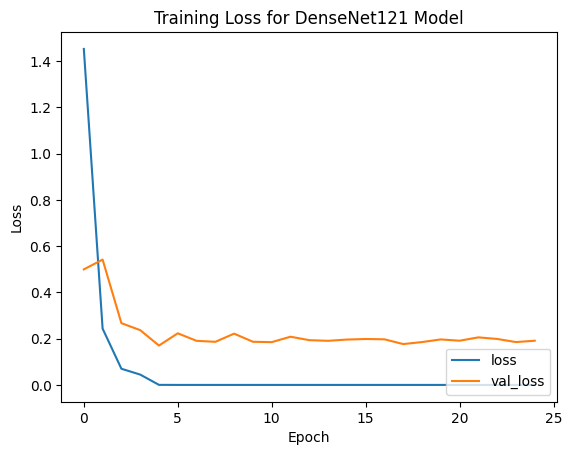

In [ ]:
plt.title('Training Loss for DenseNet121 Model')
plt.plot(model_D_history.history['loss'], label='loss')
plt.plot(model_D_history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

####Evaluate Model

In [ ]:
val_loss, val_acc = model_D.evaluate(validation_set)

print(f'Accuracy: {val_acc*100.0}')
print(f'Loss:{val_loss}')

240/240 [==============================] - 8s 34ms/step - loss: 0.1912 - accuracy: 0.9792
Accuracy: 97.91666865348816
Loss:0.1911952644586563


In [ ]:
# Get predictions from model
P = [] # empty list of predictions
Y_true = []
for i in range(len(validation_set)):
   x, y = validation_set.next()
   p = model_D.predict(x, verbose = 0)
   Y_true.extend(y)
   P.extend(p)

In [ ]:
# Convert predicted probabilities to binary predictions (0 or 1)
Y_pred = np.argmax(P, axis=1)
Y_true = np.argmax(Y_true, axis=1)

accuracy = accuracy_score(Y_true, Y_pred)
precision = precision_score(Y_true, Y_pred, average='weighted')
recall = recall_score(Y_true, Y_pred, average='weighted')
f1 = f1_score(Y_true, Y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9791666666666666
Precision: 0.9791891627388853
Recall: 0.9791666666666666
F1 Score: 0.9791043895328679


###2.3 ResNet50


####Load and Preview Model Base

In [ ]:
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
resnet_base.summary()

94765736/94765736 [==============================] - 5s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                      

####Train Model

In [ ]:
import re
resnet_base.trainable = False
for layer in resnet_base.layers:
    if bool(re.search('conv5',layer.name)):
      layer.trainable = True
      print(layer.name,": Trainable")

conv5_block1_1_conv : Trainable
conv5_block1_1_bn : Trainable
conv5_block1_1_relu : Trainable
conv5_block1_2_conv : Trainable
conv5_block1_2_bn : Trainable
conv5_block1_2_relu : Trainable
conv5_block1_0_conv : Trainable
conv5_block1_3_conv : Trainable
conv5_block1_0_bn : Trainable
conv5_block1_3_bn : Trainable
conv5_block1_add : Trainable
conv5_block1_out : Trainable
conv5_block2_1_conv : Trainable
conv5_block2_1_bn : Trainable
conv5_block2_1_relu : Trainable
conv5_block2_2_conv : Trainable
conv5_block2_2_bn : Trainable
conv5_block2_2_relu : Trainable
conv5_block2_3_conv : Trainable
conv5_block2_3_bn : Trainable
conv5_block2_add : Trainable
conv5_block2_out : Trainable
conv5_block3_1_conv : Trainable
conv5_block3_1_bn : Trainable
conv5_block3_1_relu : Trainable
conv5_block3_2_conv : Trainable
conv5_block3_2_bn : Trainable
conv5_block3_2_relu : Trainable
conv5_block3_3_conv : Trainable
conv5_block3_3_bn : Trainable
conv5_block3_add : Trainable
conv5_block3_out : Trainable


In [ ]:
model_R = Sequential()
model_R.add( resnet_base)
model_R.add( Flatten())
model_R.add( Dense(units=256, activation = 'relu' , input_dim = 7 * 7 * 2048))
model_R.add(layers.Dropout(0.5))
model_R.add( Dense(units=3, activation = 'softmax' ) )
model_R.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 256)               25690368  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                 771       
                                                                 
Total params: 49278851 (187.98 MB)
Trainable params: 25691139 (98.00 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [ ]:
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience = 20, verbose=1)
model_R.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = 'accuracy')
model_R_history = model_R.fit(training_data, validation_data = validation_set, epochs = 100, batch_size = 64, callbacks = [callback_b])

Epoch 1/100
718/718 [==============================] - 22s 23ms/step - loss: 16.2940 - accuracy: 0.4485 - val_loss: 0.9457 - val_accuracy: 0.5458
Epoch 2/100
718/718 [==============================] - 15s 21ms/step - loss: 1.8959 - accuracy: 0.5125 - val_loss: 0.9140 - val_accuracy: 0.5625
Epoch 3/100
718/718 [==============================] - 17s 24ms/step - loss: 1.4229 - accuracy: 0.5279 - val_loss: 1.7118 - val_accuracy: 0.4750
Epoch 4/100
718/718 [==============================] - 18s 24ms/step - loss: 1.4609 - accuracy: 0.5070 - val_loss: 1.6764 - val_accuracy: 0.5292
Epoch 5/100
718/718 [==============================] - 15s 21ms/step - loss: 1.4496 - accuracy: 0.5390 - val_loss: 1.1892 - val_accuracy: 0.6000
Epoch 6/100
718/718 [==============================] - 16s 23ms/step - loss: 1.6180 - accuracy: 0.5237 - val_loss: 1.8070 - val_accuracy: 0.6500
Epoch 7/100
718/718 [==============================] - 17s 24ms/step - loss: 1.3321 - accuracy: 0.5446 - val_loss: 2.2891 - val_a

####View Learning Curves

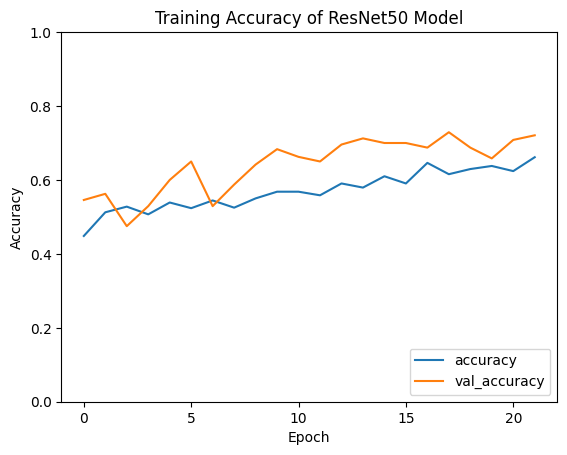

In [ ]:
plt.title('Training Accuracy of ResNet50 Model')
plt.plot(model_R_history.history['accuracy'], label='accuracy')
plt.plot(model_R_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

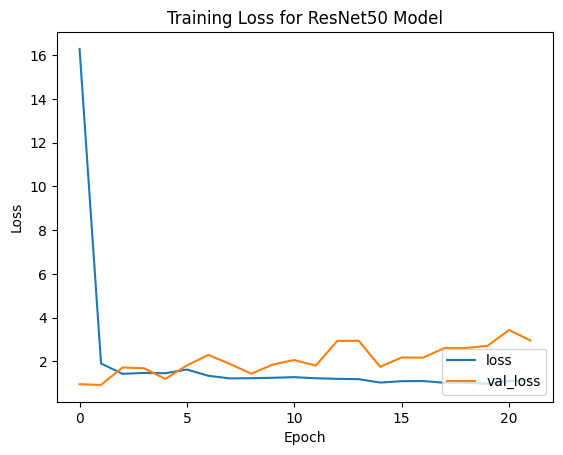

In [ ]:
plt.title('Training Loss for ResNet50 Model')
plt.plot(model_R_history.history['loss'], label='loss')
plt.plot(model_R_history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

####Evaluate Model

In [ ]:
val_loss, val_acc = model_R.evaluate(validation_set)

print(f'Accuracy: {val_acc*100.0}')
print(f'Loss:{val_loss}')

240/240 [==============================] - 3s 13ms/step - loss: 2.9477 - accuracy: 0.7208
Accuracy: 72.08333611488342
Loss:2.9476535320281982


In [ ]:
# Get predictions from model
P = [] # empty list of predictions
Y_true = []
for i in range(len(validation_set)):
   x, y = validation_set.next()
   p = model_R.predict(x, verbose = 0)
   Y_true.extend(y)
   P.extend(p)

In [ ]:
# Convert predicted probabilities to binary predictions (0 or 1)
Y_pred = np.argmax(P, axis=1)
# Y_true = np.argmax(Y_true, axis=1)

accuracy = accuracy_score(Y_true, Y_pred)
precision = precision_score(Y_true, Y_pred, average='weighted')
recall = recall_score(Y_true, Y_pred, average='weighted')
f1 = f1_score(Y_true, Y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.7208333333333333
Precision: 0.7334943421211028
Recall: 0.7208333333333333
F1 Score: 0.7233691420749248


###2.4 MobileNetV2


####Load and Preview Model Base

In [ ]:
from tensorflow.keras.applications import MobileNetV2

In [ ]:
mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
mobilenet_base.summary()

9406464/9406464 [==============================] - 2s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_4[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReL

####Train Model

In [ ]:
import re
mobilenet_base.trainable = False
for layer in mobilenet_base.layers:
    if bool(re.search('block_16',layer.name)):
      layer.trainable = True
      print(layer.name,": Trainable")

block_16_expand : Trainable
block_16_expand_BN : Trainable
block_16_expand_relu : Trainable
block_16_depthwise : Trainable
block_16_depthwise_BN : Trainable
block_16_depthwise_relu : Trainable
block_16_project : Trainable
block_16_project_BN : Trainable


In [ ]:
model_M = Sequential()
model_M.add( mobilenet_base)
model_M.add( Flatten())
model_M.add( Dense(units=25, activation = 'relu' , input_dim = 7 * 7 * 1280))
model_M.add(layers.Dropout(0.5))
model_M.add( Dense(units=3, activation = 'softmax' ) )
model_M.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten_11 (Flatten)        (None, 62720)             0         
                                                                 
 dense_26 (Dense)            (None, 25)                1568025   
                                                                 
 dropout_17 (Dropout)        (None, 25)                0         
                                                                 
 dense_27 (Dense)            (None, 3)                 78        
                                                                 
Total params: 3826087 (14.60 MB)
Trainable params: 1568103 (5.98 MB)
Non-trainable params: 2257984 (8.61 MB)
__________

In [ ]:
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience = 20, verbose=1)
model_M.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = 'accuracy')
model_M_history = model_M.fit(training_data, validation_data = validation_set, epochs = 100, batch_size = 64, callbacks = [callback_b])

Epoch 1/100
718/718 [==============================] - 15s 16ms/step - loss: 1.8934 - accuracy: 0.5125 - val_loss: 0.3982 - val_accuracy: 0.9375
Epoch 2/100
718/718 [==============================] - 10s 14ms/step - loss: 1.2639 - accuracy: 0.6727 - val_loss: 0.3077 - val_accuracy: 0.9500
Epoch 3/100
718/718 [==============================] - 20s 27ms/step - loss: 0.8519 - accuracy: 0.6964 - val_loss: 0.0691 - val_accuracy: 0.9750
Epoch 4/100
718/718 [==============================] - 13s 17ms/step - loss: 0.7683 - accuracy: 0.7145 - val_loss: 0.3718 - val_accuracy: 0.9542
Epoch 5/100
718/718 [==============================] - 13s 18ms/step - loss: 0.6733 - accuracy: 0.7368 - val_loss: 0.0782 - val_accuracy: 0.9833
Epoch 6/100
718/718 [==============================] - 11s 15ms/step - loss: 0.5272 - accuracy: 0.7953 - val_loss: 0.0832 - val_accuracy: 0.9833
Epoch 7/100
718/718 [==============================] - 10s 14ms/step - loss: 0.5916 - accuracy: 0.8008 - val_loss: 0.1151 - val_ac

####View Learning Curves

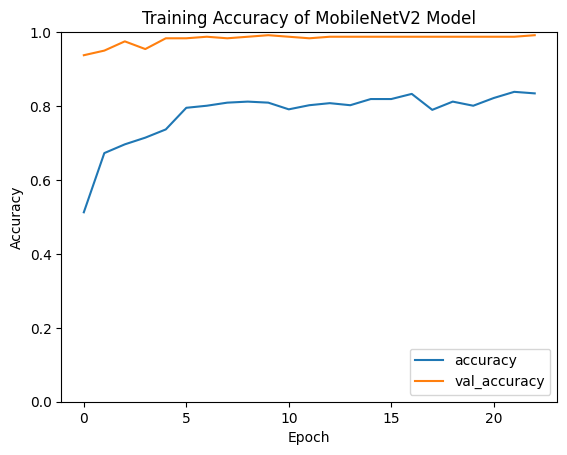

In [ ]:
plt.title('Training Accuracy of MobileNetV2 Model')
plt.plot(model_M_history.history['accuracy'], label='accuracy')
plt.plot(model_M_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

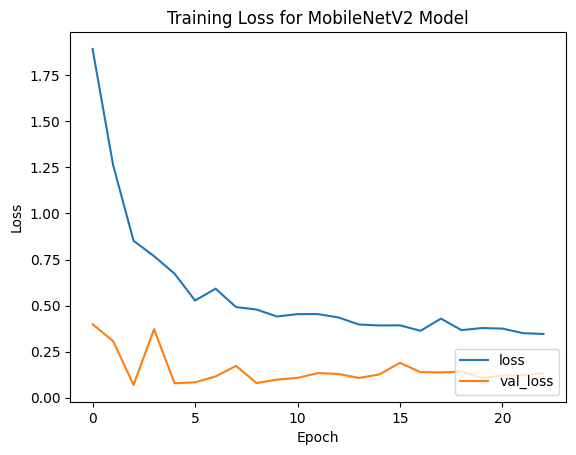

In [ ]:
plt.title('Training Loss for MobileNetV2 Model')
plt.plot(model_M_history.history['loss'], label='loss')
plt.plot(model_M_history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

####Evaluate Model

In [ ]:
val_loss, val_acc = model_M.evaluate(validation_set)

print(f'Accuracy: {val_acc*100.0}')
print(f'Loss:{val_loss}')

240/240 [==============================] - 3s 13ms/step - loss: 2.9477 - accuracy: 0.7208
Accuracy: 72.08333611488342
Loss:2.9476535320281982


In [ ]:
# Get predictions from model
P = [] # empty list of predictions
Y_true = []
for i in range(len(validation_set)):
   x, y = validation_set.next()
   p = model_M.predict(x, verbose = 0)
   Y_true.extend(y)
   P.extend(p)

In [ ]:
# Convert predicted probabilities to binary predictions (0 or 1)
Y_pred = np.argmax(P, axis=1)
Y_true = np.argmax(Y_true, axis=1)

accuracy = accuracy_score(Y_true, Y_pred)
precision = precision_score(Y_true, Y_pred, average='weighted')
recall = recall_score(Y_true, Y_pred, average='weighted')
f1 = f1_score(Y_true, Y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9916666666666667
Precision: 0.9918859649122808
Recall: 0.9916666666666667
F1 Score: 0.9916694796061883
